In [171]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import stsynphot as stsyn
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits import getheader
from astropy.io import fits
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.io.fits import getheader
from specutils import Spectrum1D
from glob import glob 
#from astropy.visualization import quantity_support
#quantity_support()  # for getting units on the axes below  
from specutils.manipulation import box_smooth
from specutils.manipulation import LinearInterpolatedResampler
import emcee
import corner
from termcolor import colored 
from multiprocessing import Pool
import warnings
from zipfile import ZipFile
from astropy import units as u
from astropy import constants as const
import pandas as pd
#custom legend
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


In [155]:
#grab anything that contains '.fits'
files = glob('*.fits')
mcfiles = glob('*emcee.h5')
# print(files)
# len(files)
mcfiles_sorted = [] # create empty list

# iterate through each value in files and if they start the same add it to the 
# new list so that mcfiles is ordered the same as files
for j in range(len(files)): 
    for i in range(len(mcfiles)):
        mcfilehead=mcfiles[i][:-9]
        if files[j]==mcfilehead:
            mcfiles_sorted.append(mcfiles[i])
            
# print('mcfiles not sorted:\n' + str(mcfiles))
# print('\nmcfiles sorted:\n' + str(mcfiles_sorted))
# print('\nfiles sorted:\n' + str(files))


In [154]:
df = pd.read_csv('/Users/kchen/Downloads/ysg.csv') # read csv
df.tail()

,Unnamed: 0,index,CommonName,teff_mc,teff_upper,teff_lower,logg_mc,logg_upper,logg_lower,radius_mc,...,halpha_emission,FYPS,source_id,lum_mc,lum_upper,lum_lower,ifmg_mc,ifmg_upper,ifmg_lower,binary
34,34,34,HD 269110,3.714772,3.714858,3.714686,1.339994,1.345750,1.334422,354.100778,...,True,False,4.652210e+18,4.912042,4.912193,4.911890,2.911542,2.917349,2.905538,1
35,35,35,HD 269787,4.070034,4.070037,4.070028,2.000034,2.000091,2.000008,122.604217,...,True,True,4.660247e+18,5.411834,5.412192,5.411475,3.672538,3.672572,3.672477,2
36,36,36,HD 269807,3.875921,3.876043,3.873462,2.724490,2.729681,2.666055,147.284732,...,False,False,4.660245e+18,4.794690,4.794852,4.794500,2.171776,2.219886,2.166660,1
37,37,37,HD 268971,4.070036,4.070037,4.070034,2.000021,2.000056,2.000005,70.605850,...,False,False,4.655053e+18,4.932517,4.932924,4.932092,3.672565,3.672584,3.672530,2
38,38,38,HD 268865,3.749584,3.749651,3.749517,1.708236,1.713505,1.703012,200.607351,...,False,False,4.661327e+18,4.557723,4.557858,4.557588,2.682544,2.687873,2.677160,1


In [5]:
# use latex for y axis
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [6]:
def fitsfile(i):
    """
    Opens fits file and prints which file it is
    """
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    return spec1d, hdr
    

In [7]:
def loademcee(i):
    """
    reads the h5 file and generates theta values where theta is [t_eff, log_g, rv, ebv, radius]
    """
    # load the file
    reader = emcee.backends.HDFBackend('/Users/kchen/FYPS/' + mcfiles_sorted[i], name='rv_prior')
    #discard first 1000 points where it's converging
    samples = reader.get_chain(flat=True, discard=1000)
    # pick 32 values between 0-128000 from the sample index and theta
    rand_ind=np.random.randint(0,127999, size=32)
    for i in rand_ind:
        theta = samples[i] #for each theta can plot each stsynphot model as trnsparent/thin posterior predictive plot
    return samples

In [189]:
def genevahr():
    """
    creates a Geneva graph on the axes of an hr diagram
    """
    masses = [12,15,20,25,32,40]
    for m in masses:
        g = pd.read_table(f'/Users/kchen/FYPS/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
                index_col='line',delim_whitespace=True)
        plt.plot(g['lg(Teff)'],g['lg(L)'],c='k',alpha=.1)
        if m != 40:
            plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1]-.05, m)
        else:
            plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1], m)
        

In [247]:
def genevashr():
    """
    Plots geneva stellar evolutionary tracks for the spectroscopic HR diagram
    """
    masses = [12,15,20,25,32,40]
    for m in masses:
        g = pd.read_table(f'/Users/kchen/FYPS/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
                index_col='line',delim_whitespace=True)
        
        #get logg
        
        rad = (np.sqrt(((10**g['lg(L)'].values)*u.L_sun)/((4*np.pi)*const.sigma_sb*((10**g['lg(Teff)'].values)**4 * u.K**4)))).to(u.cm)
        
        grav=(const.G.cgs*(g['mass'].values*u.solMass)/(rad**2)).to(u.cm / u.s ** 2)
        
        #print(grav.unit)
        
        fancyL =  4*g['lg(Teff)']-np.log10(grav.value)
        fancyLsun = 4*np.log10(5772)-np.log10(27400)
        
        fancyLf = fancyL-fancyLsun
        
        
        #plot
        plt.plot(g['lg(Teff)'],fancyLf,c='k')
        if m == 32:
            plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1]-1.4, m)
        else:
            plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1]-1.2, m)


In [235]:
def genevakiel():
    """
    Plots geneva stellar evolutionary tracks for the kiel diagram
    """
    masses = [12,15,20,25,32,40]
    for m in masses:
        g = pd.read_table(f'/Users/kchen/FYPS/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
                index_col='line',delim_whitespace=True)
        
        #get logg
        
        rad = (np.sqrt(((10**g['lg(L)'].values)*u.L_sun)/((4*np.pi)*const.sigma_sb*((10**g['lg(Teff)'].values)**4 * u.K**4)))).to(u.cm)
        
        grav=(const.G.cgs*(g['mass'].values*u.solMass)/(rad**2)).to(u.cm / u.s ** 2)
        
        #print(grav.unit)
        
        logg = np.log10(grav.value)
        
        #plot
        plt.plot(g['lg(Teff)'],logg,c='k')
        plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1], m)

In [236]:
def genevall():
    """
    Plots geneva stellar evolutionary tracks for the lum-ifmg diagram
    """
    masses = [12,15,20,25,32,40]
    for m in masses:
        g = pd.read_table(f'/Users/kchen/FYPS/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
                index_col='line',delim_whitespace=True)
        
        #get logg
        
        rad = (np.sqrt(((10**g['lg(L)'].values)*u.L_sun)/((4*np.pi)*const.sigma_sb*((10**g['lg(Teff)'].values)**4 * u.K**4)))).to(u.cm)
        
        grav=(const.G.cgs*(g['mass'].values*u.solMass)/(rad**2)).to(u.cm / u.s ** 2)
        
        #print(grav.unit)
        
        fancyL =  4*g['lg(Teff)']-np.log10(grav.value)
        fancyLsun = 4*np.log10(5772)-np.log10(27400)
        
        fancyLf = fancyL-fancyLsun
        ll = g['lg(L)']-fancyLf
        
        #plot
        plt.plot(g['lg(Teff)'],ll,c='k')
        plt.text(g['lg(Teff)'].iloc[-1]-.01,g['lg(L)'].iloc[-1], m)

In [18]:
def kieldiagram():
    """
    Plots kiel diagram of log(g) vs. t_eff for all stars in sample
    """

    # set labels
    label = 'h-alpha in emission and FYPS'
    label1 = 'h-alpha in emission and not FYPS'
    label2 = 'h-alpha not in emission and FYPS'
    label3 = 'h-alpha not in emission and not FYPS'
    
    # plot a point for each file
    for i in range(len(mcfiles_sorted)):
        samples = loademcee(i)
        x = samples[:,0]
        y = samples[:,1]
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        logg = np.percentile(y, [16, 50, 84]) # array of 16th, 50th, and 84th, percentile for logg values
        logg_median = logg[1] # median logg
        logg_ul = np.diff(logg) # diff between 16 and 50 percential and 84 and 50
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]
        logg_error = [logg_ul[0], logg_ul[1]]
        
        genevakiel()
        
        # change symbols and colors if they have h-alpha in emission or are FYPS
        if df.loc[i, 'halpha_emission'] == True:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, logg_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(logg_error).reshape(-1,1), color='red', fmt='*', label = label)
                label = None
            else:
                plt.errorbar(teff_median, logg_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(logg_error).reshape(-1,1), color='tab:blue', fmt='*', label=label1)
                label1 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, logg_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(logg_error).reshape(-1,1), color='red', fmt='o', label=label2)
                label2 = None
            else:
                plt.errorbar(teff_median, logg_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(logg_error).reshape(-1,1), color='tab:blue', fmt='o', label=label3)
                label3 = None
    plt.xlim(4.2, 3.5)
    plt.gca().invert_yaxis()
    plt.ylabel('log(g)', fontsize = 15)
    plt.xlabel('Temperature (K)', fontsize = 15)
    plt.legend(loc='lower left')
    plt.title('Kiel Diagram', fontsize=18)

In [22]:
def spechr():
    """
    generates spectroscopic Hertzsprung Russel diagram
    """
    
    # set labels
    label = 'h-alpha in emission and FYPS'
    label1 = 'h-alpha in emission and not FYPS'
    label2 = 'h-alpha not in emission and FYPS'
    label3 = 'h-alpha not in emission and not FYPS'
    
    
    for i in range(len(mcfiles_sorted)):
        samples = loademcee(i)
        x = samples[:,0] #teff
        y = samples[:,1] #logg
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute fancy L
        fancyL =  4*np.log10(x)-y
        fancyLsun = 4*np.log10(5772)-np.log10(27400)
        
        fancyLp = np.percentile(fancyL, [16, 50, 84]) - fancyLsun # percentiles of fancy L
        l_median = fancyLp[1] # median fancy L
        fancyL_ul = np.diff(fancyLp)
        l_error = [fancyL_ul[0], fancyL_ul[1]] # error bars for L
        
        genevashr()
        
        if df.loc[i, 'halpha_emission'] == True:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='*', label = label)
                label = None
            else:
                plt.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='*', label=label1)
                label1 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='o', label=label2)
                label2 = None
            else:
                plt.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='o', label=label3)
                label3 = None
    plt.ylabel(r'log($\mathcal{L}/\mathcal{L}_\odot$)', fontsize=15)
    plt.xlabel('Temperature (K)', fontsize=15)
    plt.legend(loc='lower left')
    plt.xlim(4.2, 3.5)
    plt.title('Spectroscopic Hertzsprung-Russel Diagram', fontsize=18)

In [53]:
def hr():
    """
    generates Hertzsprung Russel diagram
    """
    
    # set labels
    label = 'h-alpha in emission and FYPS'
    label1 = 'h-alpha in emission and not FYPS'
    label2 = 'h-alpha not in emission and FYPS'
    label3 = 'h-alpha not in emission and not FYPS'
    
    
    for i in range(len(mcfiles_sorted)):
        samples = loademcee(i)
        x = samples[:,0] #teff
        y = samples[:,1] #logg
        z = samples[:,4] # radius
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute L with Stefan Boltzmann equation
        L = (((4*np.pi))*(z**2 * u.R_sun**2)*const.sigma_sb*(x**4 * u.K**4)).to(u.L_sun) # Stefan-Boltzmann equation to get L
        sb = np.log10(L.value) # log(L/L_odot)
        
        sbp = np.percentile(sb, [16, 50, 84]) # percentiles of L
        sb_median = sbp[1]
        sb_ul = np.diff(sbp)
        sb_error = [sb_ul[0], sb_ul[1]] # errors
                                         
        # using photometric data
        
        teff_pm = df.teff_pm[i]
        lum = df.lum_pm[i]
        
                            
        
        x_plot = [teff_pm, teff_median] #x vals
        y_plot = [lum, sb_median]#y vals linestyle="--"
        
        genevahr()
        
        # h-alpha in emission - star (circle if not)
        if df.loc[i, 'halpha_emission'] == True:
            # ysg - red (blue if not)
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1), color='red', fmt='v', label=label)
                plt.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], color='red', fmt='v', mfc='none')
                label = None
            else:
                plt.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1), color='tab:blue', fmt='v', label=label1)
                plt.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], color='tab:blue', fmt='v', mfc='none')
                label1 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1), color='red', fmt='o', label=label2)
                plt.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], color='red', fmt='o')
                label2 = None
            else:
                plt.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1), color='tab:blue', fmt='o', label=label3)
                plt.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], color='tab:blue', fmt='o', mfc='none')
                label3 = None
        plt.plot(x_plot, y_plot, linestyle='--', color='black')
    plt.xlim(4.2, 3.5)
    plt.ylabel(r'log($L/L_\odot$)', fontsize=15)
    plt.xlabel('Temperature (K)', fontsize=15)
    plt.legend(loc='lower left')
    plt.title('Hertzsprung-Russel Diagram', fontsize=18)

In [49]:
def ll():
    
    label = 'h-alpha in emission and FYPS'
    label1 = 'h-alpha in emission and not FYPS'
    label2 = 'h-alpha not in emission and FYPS'
    label3 = 'h-alpha not in emission and not FYPS'
    
    for i in range(len(mcfiles_sorted)):
        # x-axis
        samples = loademcee(i)
        x = samples[:,0]
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        
        teff_median = df.teff_mc[i]
        
        
        # y-axis, diff between two
        fancyL = df.ifmg_mc[i]
        lum = df.lum_mc[i]
        ll = lum-fancyL
        
        ll_lower = abs((lum-df.lum_lower[i])-(fancyL-df.ifmg_lower[i]))
        ll_upper = abs((df.lum_upper[i]-lum)-(df.ifmg_upper[i]-fancyL))
        
        # errors
        teff_error = [teff_ul[0], teff_ul[1]]
        ll_error = [ll_lower, ll_upper]
        
        #geneva
        genevall()
        
        # plot
        if df.loc[i, 'halpha_emission'] == True:
            # ysg - red (blue if not)
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, ll, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='v', label=label)
                label = None
            else:
                plt.errorbar(teff_median, ll, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='v', label=label1)
                label1 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                plt.errorbar(teff_median, ll, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='o', label=label2)
                label2 = None
            else:
                plt.errorbar(teff_median, ll, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='o', label=label3)
                label3 = None
        
        
    plt.xlim(4.2, 3.5)
    plt.ylabel(r'log($L/L_\odot$)-log($\mathcal{L}/\mathcal{L}_\odot$)', fontsize=15)
    plt.xlabel('Temperature (K)', fontsize=15)
    plt.legend(loc='upper left')
    plt.title('Lum-IFMG Diagram', fontsize=18)

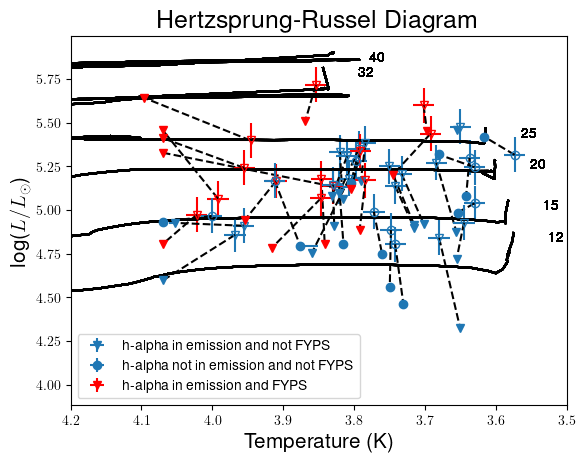

In [161]:
hr()

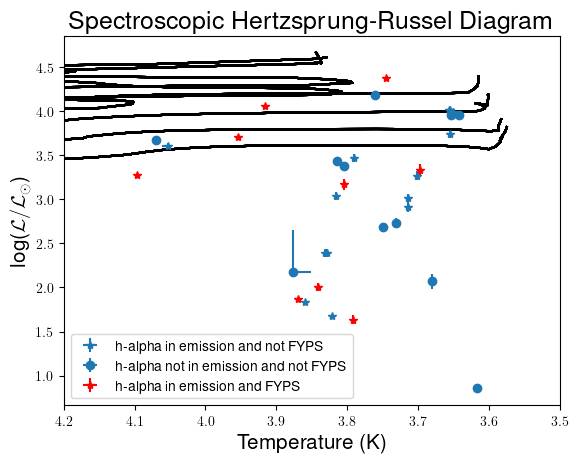

In [24]:
spechr()

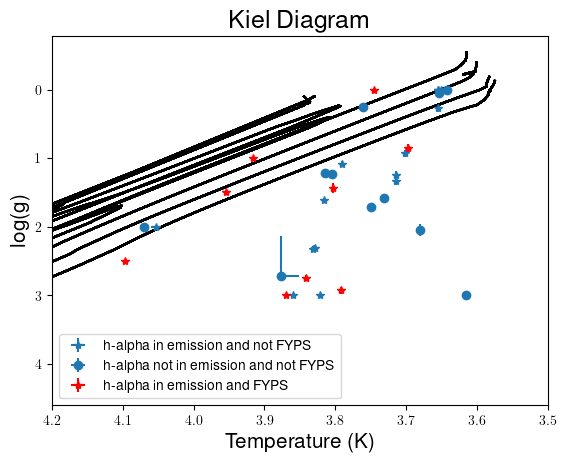

In [25]:
kieldiagram()

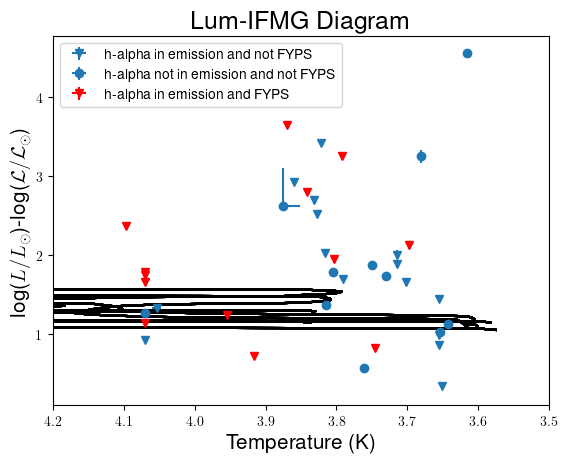

In [52]:
ll()

In [264]:
def spechrbin():
    """
    generates spectroscopic Hertzsprung Russel diagram considering binarity now
    """
    fig, ax = plt.subplots(dpi=300)
    
    # set labels
    red_patch = mpatches.Patch(color='red', label='FYPS')
    blue_patch = mpatches.Patch(color='tab:blue', label='Not FYPS')
    triangle = Line2D([0], [0], label='halpha in emission', marker='v', markeredgewidth=0, markersize=10, markerfacecolor='k', markeredgecolor=None, linestyle='')
    circle = Line2D([0], [0], label='halpha not in emission', marker='o', markeredgewidth=0, markersize=10, markerfacecolor='k', markeredgecolor=None, linestyle='')
    squarebin = Line2D([0], [0], label='binary', marker='s', markersize=10, markerfacecolor='None', markeredgecolor='k', markeredgewidth=2, linestyle='')
    squaremaybe = Line2D([0], [0], label='maybe binary', marker='s', markersize=10, markerfacecolor='None', markeredgecolor='purple', markeredgewidth=2, linestyle='')
    line = Line2D([0], [0], label='Geneva evolutionary track', color='k')
    
    
    
    for i in range(len(mcfiles_sorted)):
        samples = loademcee(i)
        x = samples[:,0]
        y = samples[:,1]
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute fancy L
        fancyL =  4*np.log10(x)-y
        fancyLsun = 4*np.log10(5772)-np.log10(27400)
        
        fancyLp = np.percentile(fancyL, [16, 50, 84]) - fancyLsun # percentiles of fancy L
        l_median = fancyLp[1] # median fancy L
        fancyL_ul = np.diff(fancyLp)
        l_error = [fancyL_ul[0], fancyL_ul[1]] # error bars for L
        
        genevashr()
        

        if df.loc[i, 'halpha_emission'] == True:
            if df.loc[i, 'FYPS'] == True:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='v', markersize=10, zorder=11)

                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='v', markersize=10, mec='k', markeredgewidth=2, zorder=10)
                    
                else:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='v', markersize=10, mec='rebeccapurple', markeredgewidth=2, zorder=10)
                    
            else:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10)
                    
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, mec='k', markeredgewidth=2)
                    
                else:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, mec='rebeccapurple', markeredgewidth=2)
                    
        else:
            if df.loc[i, 'FYPS'] == True:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='o', markersize=10, zorder=10)
                    
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='o', markersize=10, mec='k', markeredgewidth=2, zorder=10)
                    
                else:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='red', fmt='o', markersize=10, mec='rebeccapurple', markeredgewidth=2, zorder=10)
                    
            else:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10)
                    
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, mec='k', markeredgewidth=2)
                    
                else:
                    ax.errorbar(teff_median, l_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(l_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, mec='rebeccapurple', markeredgewidth=2)
                    
    ax.set_ylabel(r'$\log(\mathcal{L}/\mathcal{L}_\odot)$', fontsize=15)
    ax.set_xlabel(r'$\log(T_{\rm eff})$', fontsize=15)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=[red_patch, blue_patch, triangle, circle, squarebin, squaremaybe, line])
    ax.set_xlim(4.2, 3.5)
    ax.set_title('Spectroscopic Hertzsprung-Russel Diagram', fontsize=18)

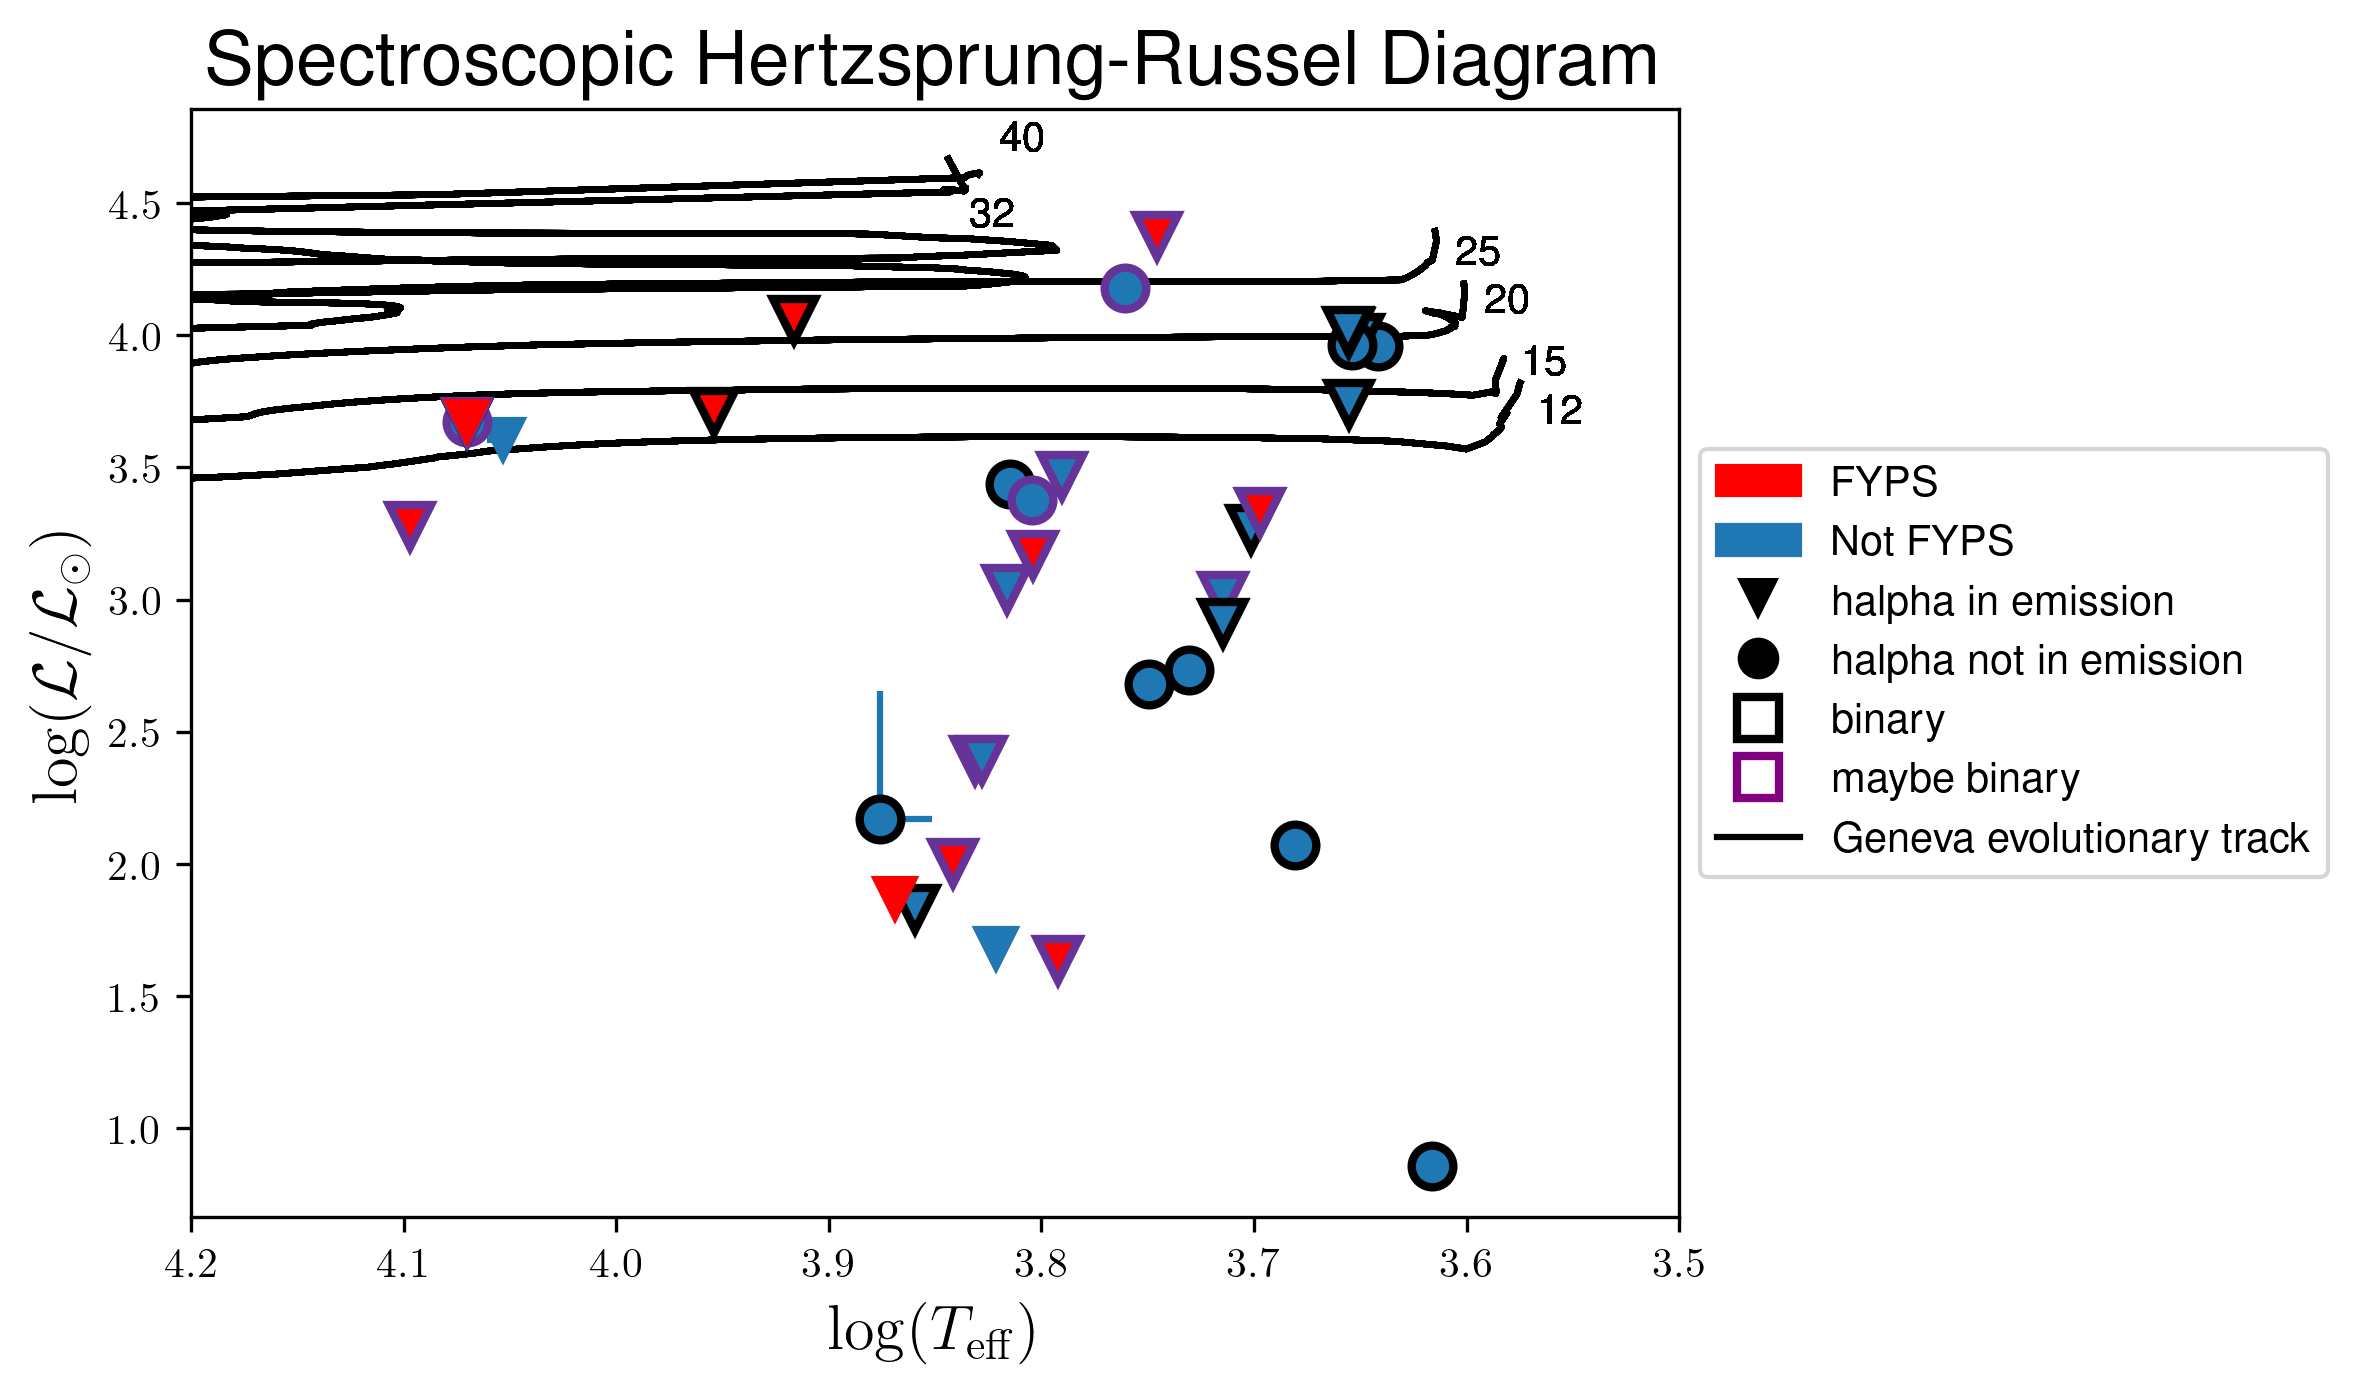

In [265]:
spechrbin()

In [144]:
def llbin():
    """
    creates lum-ifmg diagram and considers if the star is or isn't binary
    """
    
    fig, ax = plt.subplots(dpi=300)
    
    # set labels
    label = 'h-alpha in emission and FYPS not binary'
    label0 = 'h-alpha in emission and FYPS binary'
    label01 = 'h-alpha in emission and FYPS maybe binary'
    label1 = 'h-alpha in emission and not FYPS not binary'
    label10 = 'h-alpha in emission and not FYPS binary'
    label11 = 'h-alpha in emission and not FYPS maybe binary'
    label2 = 'h-alpha not in emission and FYPS not binary'
    label20 = 'h-alpha not in emission and FYPS binary'
    label21 = 'h-alpha not in emission and FYPS maybe binary'
    label3 = 'h-alpha not in emission and not FYPS not binary'
    label30 = 'h-alpha not in emission and not FYPS binary'
    label31 = 'h-alpha not in emission and not FYPS maybe binary'
    
    for i in range(len(mcfiles_sorted)):
        # x-axis
        samples = loademcee(i)
        x = samples[:,0]
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        
        teff_median = df.teff_mc[i]
        
        
        # y-axis, diff between two
        fancyL = df.ifmg_mc[i]
        lum = df.lum_mc[i]
        ll_median = lum-fancyL
        
        ll_lower = abs((lum-df.lum_lower[i])-(fancyL-df.ifmg_lower[i]))
        ll_upper = abs((df.lum_upper[i]-lum)-(df.ifmg_upper[i]-fancyL))
        
        # errors
        teff_error = [teff_ul[0], teff_ul[1]]
        ll_error = [ll_lower, ll_upper]
        
        #geneva
        genevall()
        
        # plot
        
        #halpha emission triangle, circle if not

        if df.loc[i, 'halpha_emission'] == True:
            if df.loc[i, 'FYPS'] == True:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='v', markersize=10, label = label, zorder=11)
                    label = None
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='v', markersize=10, label = label0, mec='k', markeredgewidth=2, zorder=10)
                    label0 = None
                else:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='v', markersize=10, label = label01, mec='rebeccapurple', markeredgewidth=2, zorder=10)
                    label01 = None
            else:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, label = label1)
                    label1 = None
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, label = label10, mec='k', markeredgewidth=2)
                    label10 = None
                else:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='v', markersize=10, label = label11, mec='rebeccapurple', markeredgewidth=2)
                    label11 = None
        else:
            if df.loc[i, 'FYPS'] == True:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='o', markersize=10, label = label2, zorder=10)
                    label2 = None
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='o', markersize=10, label = label20, mec='k', markeredgewidth=2, zorder=10)
                    label20 = None
                else:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='red', fmt='o', markersize=10, label = label21, mec='rebeccapurple', markeredgewidth=2, zorder=10)
                    label21 = None
            else:
                if df.loc[i, 'binary'] == 0:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, label = label3)
                    label3 = None
                elif df.loc[i, 'binary'] == 1:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, label = label30, mec='k', markeredgewidth=2)
                    label30 = None
                else:
                    ax.errorbar(teff_median, ll_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(ll_error).reshape(-1,1), color='tab:blue', fmt='o', markersize=10, label = label31, mec='rebeccapurple', markeredgewidth=2)
                    label31 = None
        
   # plt.subplots(dpi=300)[1]   
    ax.set_xlim(4.2, 3.5)
    ax.set_ylabel(r'\log($L/L_\odot$)-log($\mathcal{L}/\mathcal{L}_\odot$)', fontsize=15)
    ax.set_xlabel(r'$\log(T_{\rm eff}$)', fontsize=15)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Lum-IFMG Diagram', fontsize=18)

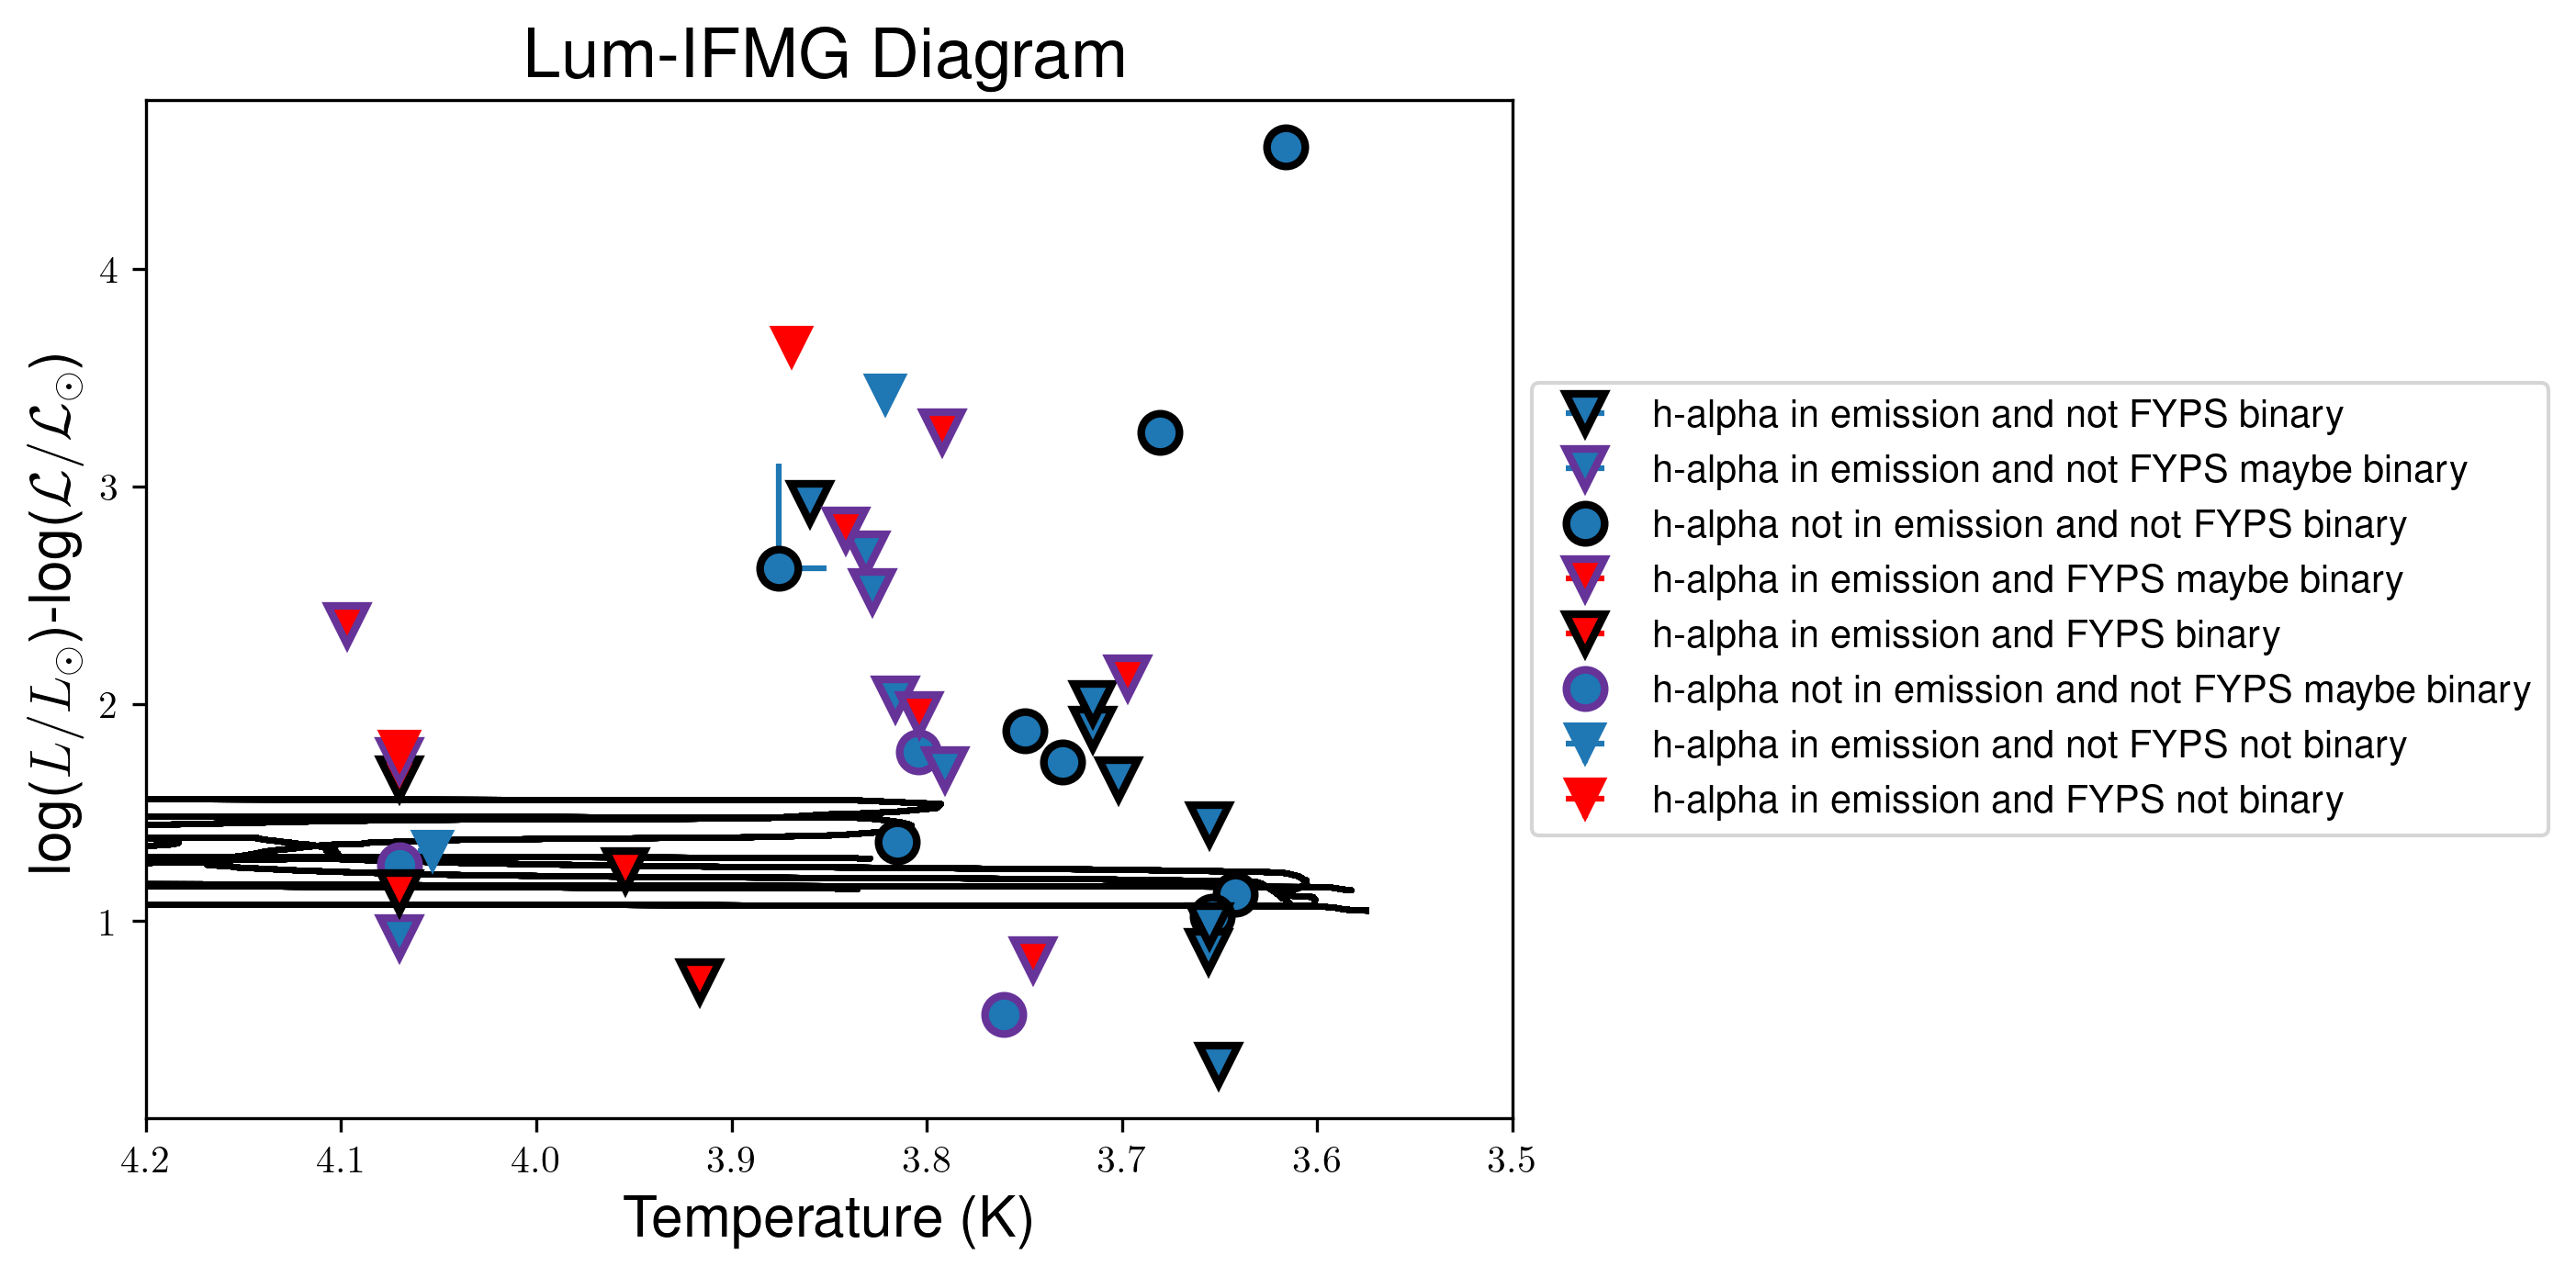

In [145]:
llbin()

In [226]:
def hrspec():
    """
    generates Hertzsprung Russel diagram
    """
    fig, ax = plt.subplots(dpi=300)
    
    # set labels
    
    red_patch = mpatches.Patch(color='red', label='FYPS')
    blue_patch = mpatches.Patch(color='tab:blue', label='Not FYPS')
    triangle = Line2D([0], [0], label='halpha in emission', marker='v', markeredgewidth=0, markersize=10, markerfacecolor='k', markeredgecolor=None, linestyle='')
    circle = Line2D([0], [0], label='halpha in emission', marker='o', markeredgewidth=0, markersize=10, markerfacecolor='k', markeredgecolor=None, linestyle='')
    line = Line2D([0], [0], label='Geneva evolutionary track', color='k')
    
    
    for i in range(len(mcfiles_sorted)):
        samples = loademcee(i)
        x = samples[:,0] #teff
        y = samples[:,1] #logg
        z = samples[:,4] # radius
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute L with Stefan Boltzmann equation
        L = (((4*np.pi))*(z**2 * u.R_sun**2)*const.sigma_sb*(x**4 * u.K**4)).to(u.L_sun) # Stefan-Boltzmann equation to get L
        sb = np.log10(L.value) # log(L/L_odot)
        
        sbp = np.percentile(sb, [16, 50, 84]) # percentiles of L
        sb_median = sbp[1]
        sb_ul = np.diff(sbp)
        sb_error = [sb_ul[0], sb_ul[1]] # errors
                                         
        # using photometric data
        
        teff_pm = df.teff_pm[i]
        lum = df.lum_pm[i]
        
                            
        
        x_plot = [teff_pm, teff_median] #x vals
        y_plot = [lum, sb_median]#y vals linestyle="--"
        
        genevahr()
        
        # h-alpha in emission - star (circle if not)
        if df.loc[i, 'halpha_emission'] == True:
            # ysg - red (blue if not)
            if df.loc[i, 'FYPS'] == True:
                ax.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1),  markersize=10, color='red', fmt='v')
                
            else:
                ax.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1),  markersize=10, color='tab:blue', fmt='v')
               
        else:
            if df.loc[i, 'FYPS'] == True:
                ax.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1),  markersize=10, color='red', fmt='o')
                
            else:
                ax.errorbar(teff_median, sb_median, xerr=10*np.array(teff_error).reshape(-1,1), yerr=10*np.array(sb_error).reshape(-1,1),  markersize=10, color='tab:blue', fmt='o')
                
    ax.set_xlim(4.2, 3.5)
    ax.set_ylabel(r'$log(L/L_\odot)$', fontsize=15)
    ax.set_xlabel(r'$log(T_{\rm eff})$', fontsize=15)
    ax.legend(loc='lower left', handles=[red_patch, blue_patch, triangle, circle, line])

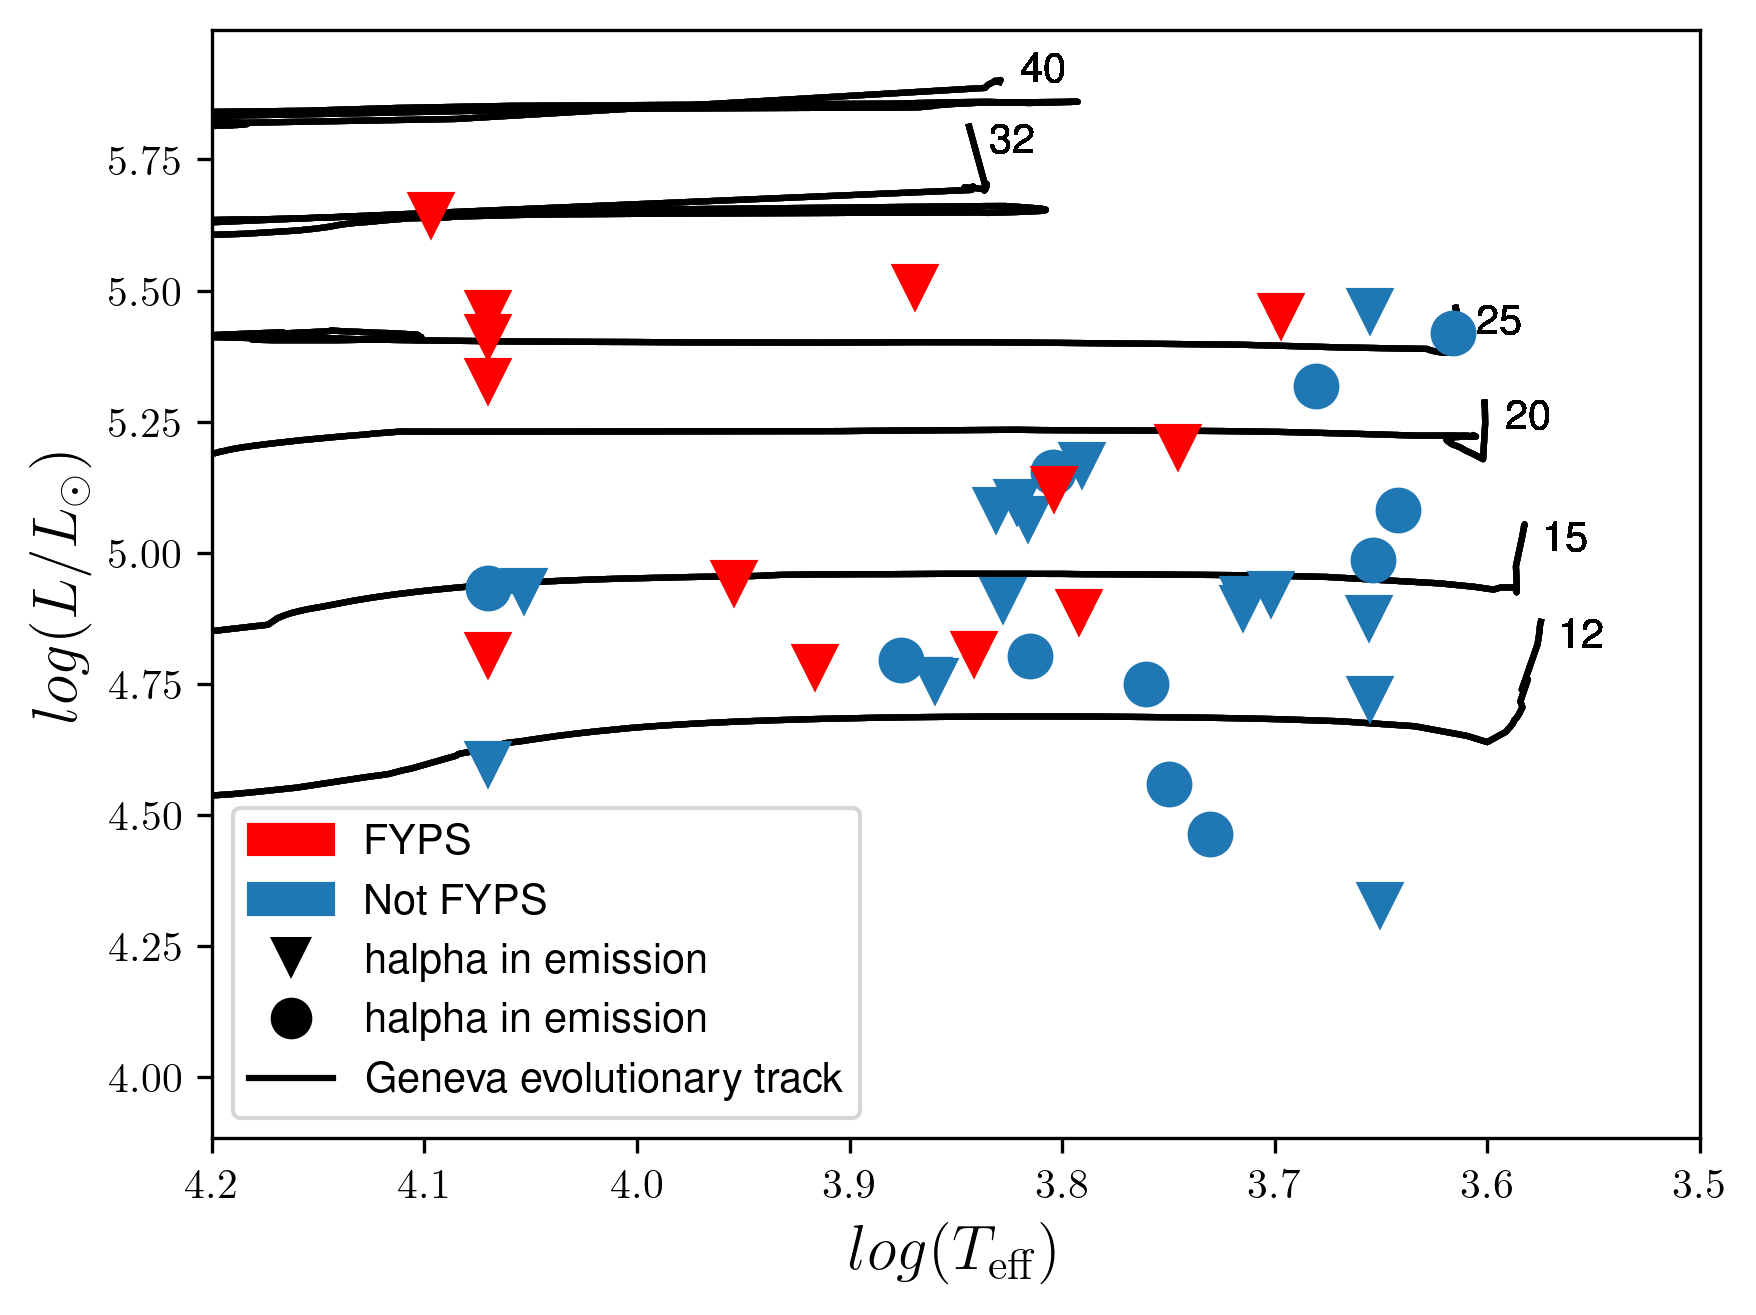

In [227]:
hrspec()

In [260]:
def hrpm():
    """
    generates Hertzsprung Russel diagram
    """
    fig, ax = plt.subplots(dpi=300)

    # set labels
    
    red_patch = mpatches.Patch(color='red', label='FYPS')
    blue_patch = mpatches.Patch(color='tab:blue', label='Not FYPS')
    triangle = Line2D([0], [0], label='halpha in emission', marker='v', markeredgewidth=0, markersize=10, markerfacecolor='k', markeredgecolor=None, linestyle='')
    circle = Line2D([0], [0], label='halpha not in emission', marker='o', markeredgewidth=0, markersize=10, markerfacecolor='k', markeredgecolor=None, linestyle='')
    line = Line2D([0], [0], label='Geneva evolutionary track', color='k')
    
    
    for i in range(len(mcfiles_sorted)):
        samples = loademcee(i)
        x = samples[:,0] #teff
        y = samples[:,1] #logg
        z = samples[:,4] # radius
        teff = np.log10(np.percentile(x, [16, 50, 84])) # array of 16th, 50th, and 84th, percentile for teff values
        teff_ul = np.diff(teff) # diff between 16 and 50 percential and 84 and 50
        teff_median = teff[1] # median teff
        
        
        #error
        teff_error = [teff_ul[0], teff_ul[1]]

        
        #compute L with Stefan Boltzmann equation
        L = (((4*np.pi))*(z**2 * u.R_sun**2)*const.sigma_sb*(x**4 * u.K**4)).to(u.L_sun) # Stefan-Boltzmann equation to get L
        sb = np.log10(L.value) # log(L/L_odot)
        
        sbp = np.percentile(sb, [16, 50, 84]) # percentiles of L
        sb_median = sbp[1]
        sb_ul = np.diff(sbp)
        sb_error = [sb_ul[0], sb_ul[1]] # errors
                                         
        # using photometric data
        
        teff_pm = df.teff_pm[i]
        lum = df.lum_pm[i]
        
                            
        
        x_plot = [teff_pm, teff_median] #x vals
        y_plot = [lum, sb_median]#y vals linestyle="--"
        
        genevahr()
        
        # h-alpha in emission - star (circle if not)
        if df.loc[i, 'halpha_emission'] == True:
            # ysg - red (blue if not)
            if df.loc[i, 'FYPS'] == True:
                ax.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], markersize=10, color='red', fmt='v', mfc='none')
                
            else:
                ax.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], markersize=10, color='tab:blue', fmt='v', mfc='none')
                
        else:
            if df.loc[i, 'FYPS'] == True:
                ax.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], markersize=10, color='red', fmt='o', mfc='none')
                
            else:
                ax.errorbar(teff_pm, lum, xerr=[.015], yerr=[0.1], markersize=10, color='tab:blue', fmt='o', mfc='none')
                
    ax.set_xlim(4.2, 3.5)
    ax.set_ylabel(r'$log(L/L_\odot)$', fontsize=15)
    ax.set_xlabel(r'$log(T_{eff})$', fontsize=15)
    plt.legend(loc='lower left', handles=[red_patch, blue_patch, triangle, circle, line])

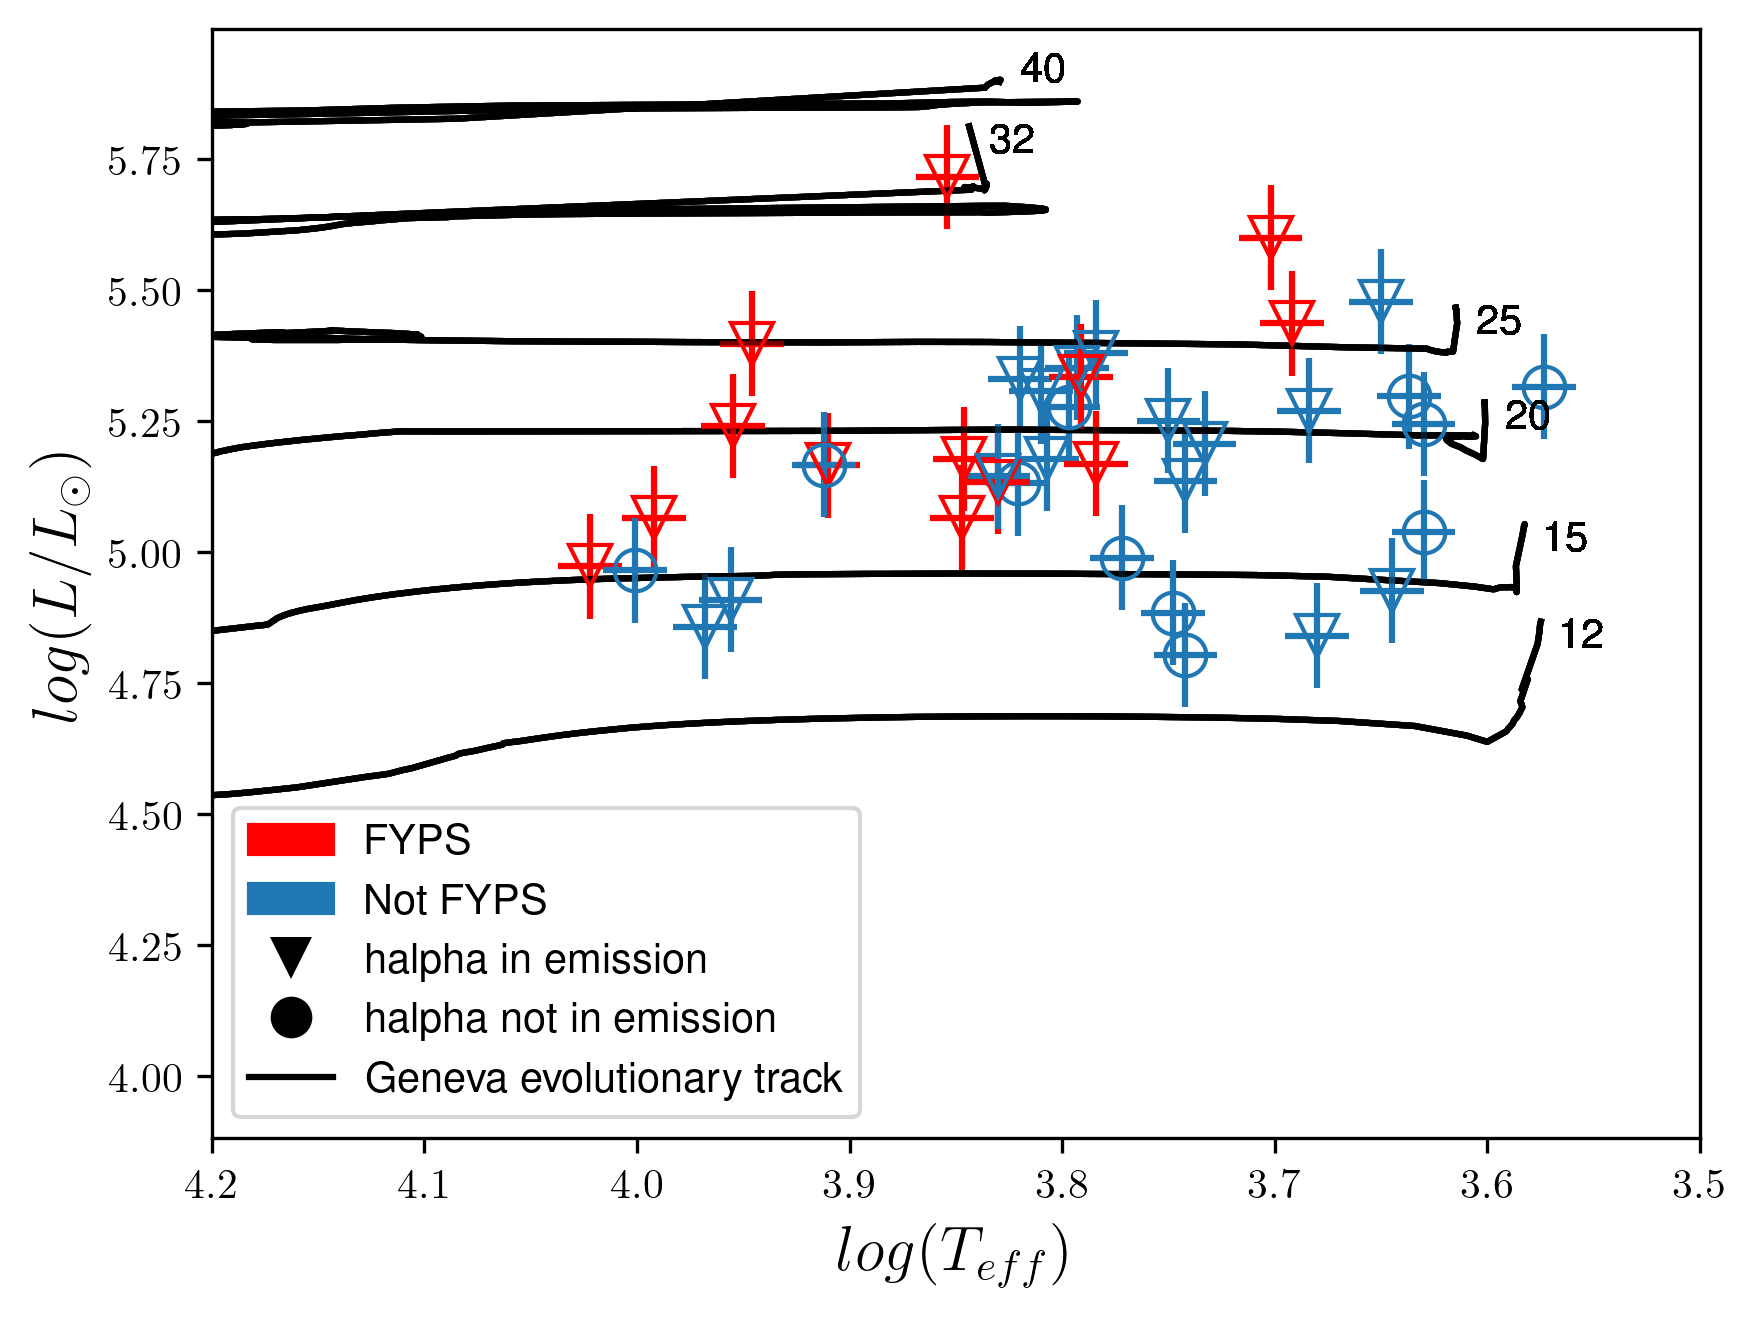

In [261]:
hrpm()

In [256]:
def histteff():
    """
    differences in teff from mc values vs photometric
    """
    fig, ax = plt.subplots(dpi=300)
    x = []
    for i in range(len(mcfiles_sorted)):
        diff = df.loc[i, 'teff_mc']-df.loc[i, 'teff_pm']
        x.append(diff)
    ax.hist(x, bins='auto')
    ax.set_xlabel(r'$\Delta\log{T_{\rm eff}}$', fontsize=15)
    ax.set_ylabel('Number of Stars', fontsize=15)

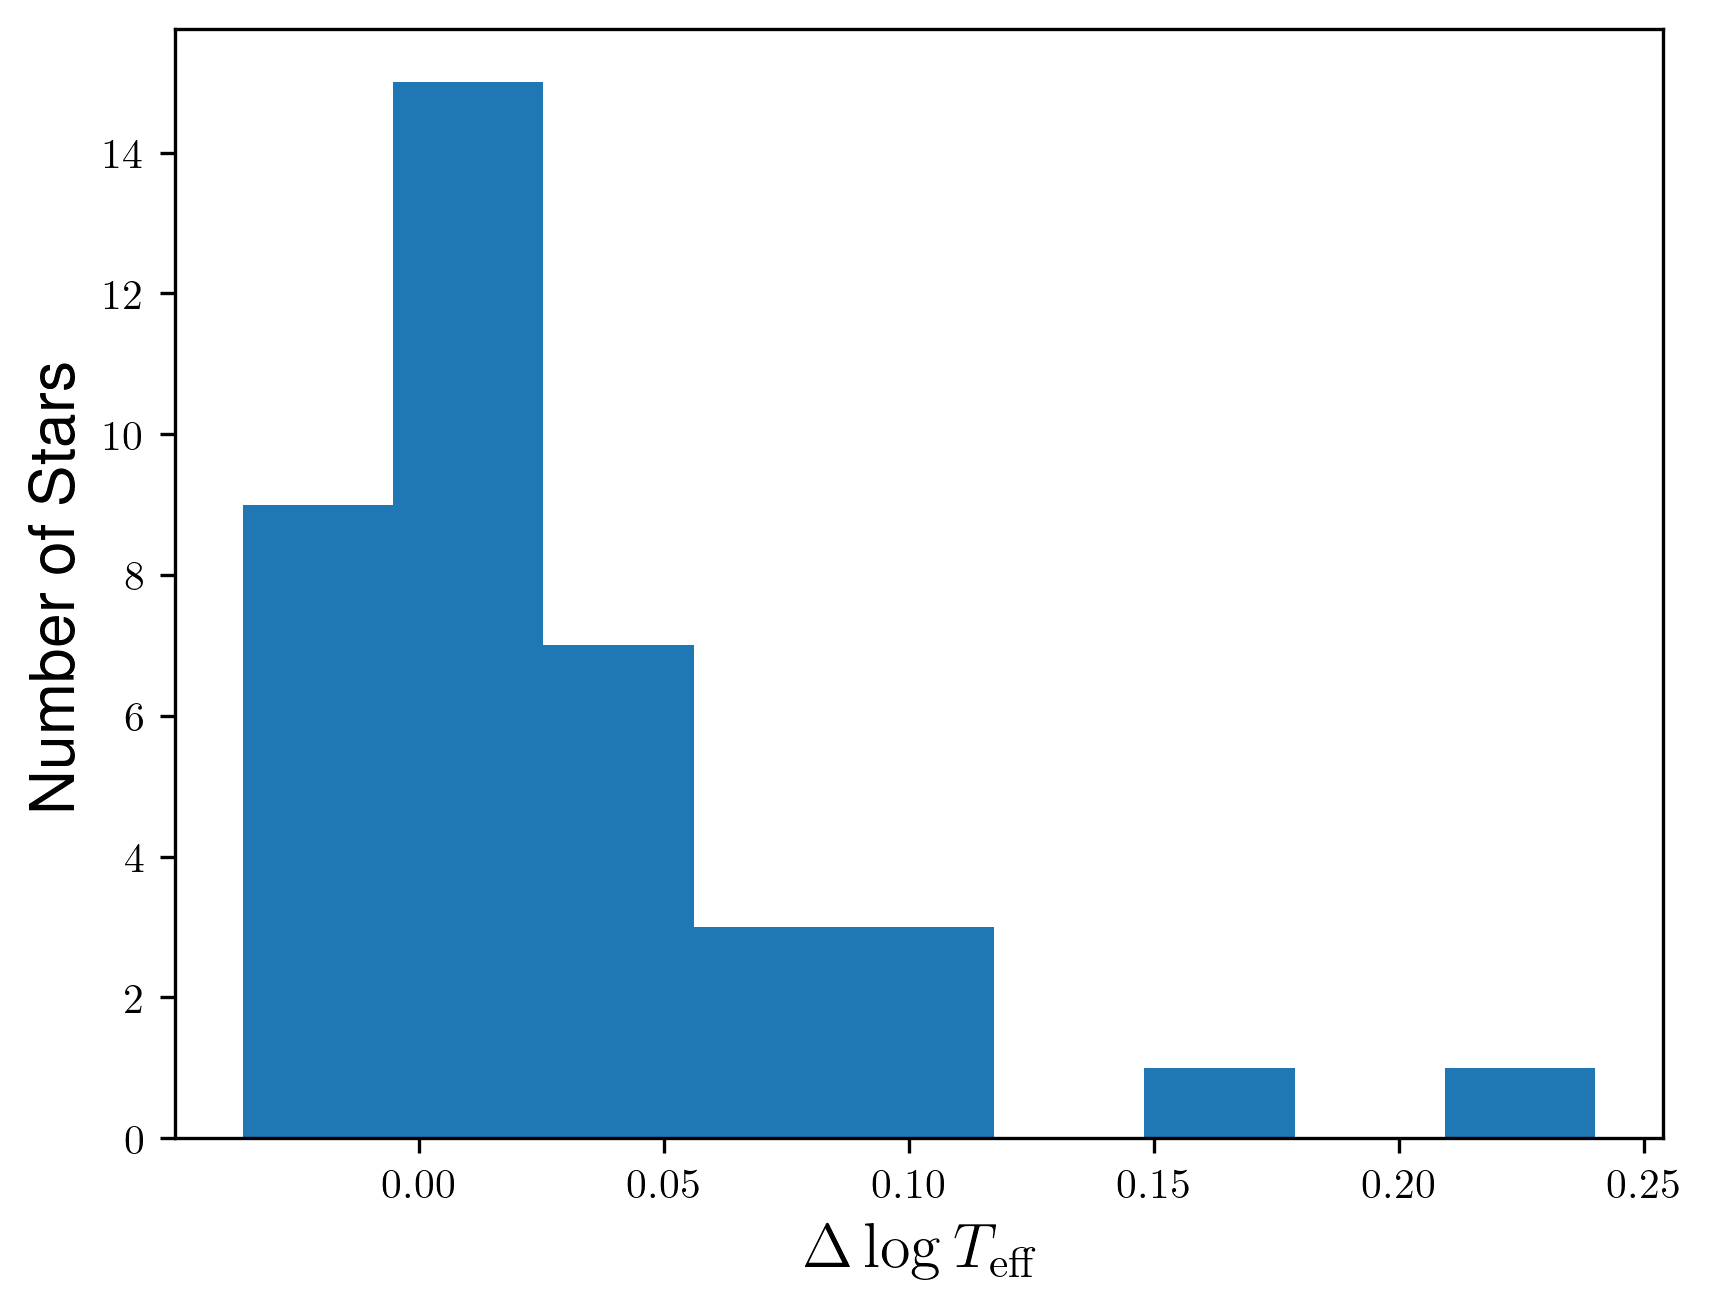

In [257]:
histteff()

In [258]:
def histlum():
    """
    differences in log(L) from mc values vs photometric
    """
    fig, ax = plt.subplots(dpi=300)
    x = []
    for i in range(len(mcfiles_sorted)):
        diff = df.loc[i, 'lum_mc']-df.loc[i, 'lum_pm']
        x.append(diff)
    ax.hist(x, bins='auto')
    ax.set_xlabel(r'$\Delta\log{L/L_\odot}$', fontsize=15)
    ax.set_ylabel('Number of Stars', fontsize=15)

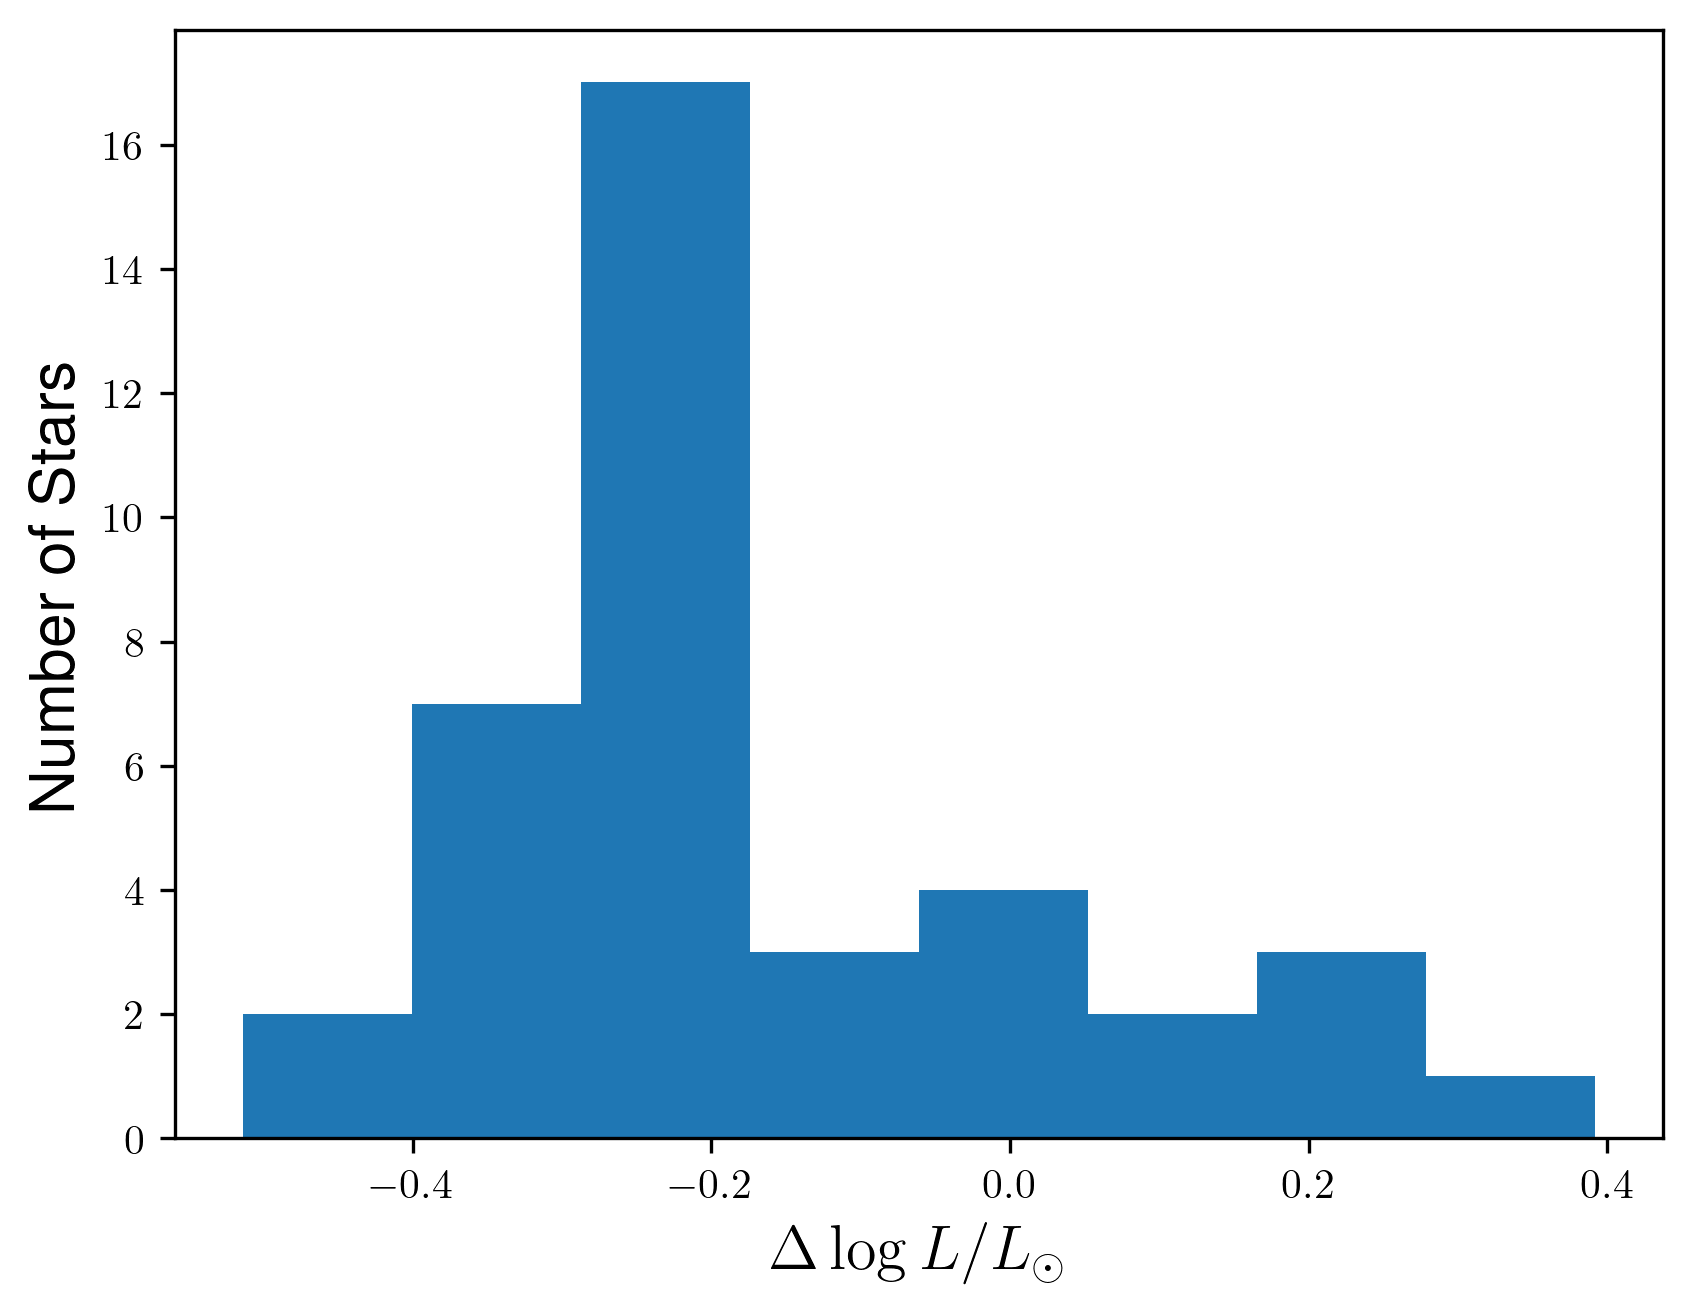

In [259]:
histlum()